# Creation Sdata object Visium HD

## Import + install packages

In [33]:
import os
os.environ["QT_QPA_PLATFORM"] = "xcb"
os.environ["LIBGL_ALWAYS_SOFTWARE"] = "1"

import spatialdata as sd
import spatialdata_plot
import spatialdata_io as visium
import os
import pandas as pd
import numpy as np
import scanpy as sc

In [37]:
# Set working directory
working_dir = os.getcwd()
data_path = working_dir

print("Working dir: ",data_path)

# Load the visium_HD data into a spatial data object
sdata = visium.visium_hd(data_path, dataset_id="",filtered_counts_file = True,load_all_images=True)

Working dir:  /home/sarah/Documents/Design_project/spotless-benchmark/proportions/visium_HD


/home/sarah/anaconda3/envs/spatial_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_4233/648522856.py:8: UserWarning: No full resolution image found. If incorrect, please specify the path in the `fullres_image_file` parameter when calling the `visium_hd` reader function.
  sdata = visium.visium_hd(data_path, dataset_id="",filtered_counts_file = True,load_all_images=True)


In [27]:
#Print structure sdata object
print(sdata)

SpatialData object
├── Images
│     ├── '_cytassist_image': DataArray[cyx] (3, 3000, 3200)
│     ├── '_hires_image': DataArray[cyx] (3, 3958, 6000)
│     └── '_lowres_image': DataArray[cyx] (3, 396, 600)
├── Shapes
│     └── '_square_016um': GeoDataFrame shape: (115975, 1) (2D shapes)
└── Tables
      └── 'square_016um': AnnData (115975, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        _hires_image (Images), _square_016um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        _lowres_image (Images), _square_016um (Shapes)
    ▸ 'global', with elements:
        _cytassist_image (Images), _square_016um (Shapes)


In [ ]:
#load assigment file
assig = pd.read_csv("assignments.csv")
assig.index = assig['Unnamed: 0']+"-1"

#add parts to the sdata object based on indexmapping
sdata.tables['square_016um'].obs = sdata.tables['square_016um'].obs.join(assig['part'])

#overview data_characteristics
#Matrix X: for each spot it contains the number of UMI counts for each gen
#each RNA molecule gets a different UMI
sdata.tables['square_016um'].obs["total_n_UMI_per_spot"] = sdata.tables['square_016um'].X.sum(axis=1).A1 #The total number of UMI's per spot
sdata.tables['square_016um'].var["n_spots_by_counts"] = (sdata.tables['square_016um'].X > 0).sum(axis=0).A1 #The total number of different spot that contains a certain gene.
sdata.tables['square_016um'].obs["n_genes_by_counts"] = (sdata.tables['square_016um'].X > 0).sum(axis=1).A1 #The total number of different genes that are expressed in a certain spot.

print(f'The original AnnData object contains: {sdata.tables['square_016um'].n_obs} spots and {sdata.tables['square_016um'].n_vars} genes. The original count is stored in AnnData.X')

#write output
#sdata.tables['square_016um'].obs[["total_n_UMI_per_spot","n_genes_by_counts"]].to_csv("spot_distribution_metadata_visium_HD.csv")


The original AnnData object contains: 115975 spots and 19059 genes. The original count is stored in AnnData.X


In [29]:
# Check data formats
print("Input pipeline part 0 (part_0.h5ad)")
adata = sc.read("part_0.h5ad")
print(adata.obs['part'].head())

print("\nAssignemt.csv (selected part 0)")
art_mask = assig["part"] == 0
print(assig[art_mask].head())
print("\nSame order in assigment.csv for a certain part as in the input file for the pipeline\n")
print(50*'--')

data_part_0 = pd.read_csv("visium_HD_cell2location_2x2/proportions_cell2location_part_0.csv",delimiter = '\t')
print("\nResults (cell2loc_visium_hd_part_0)")
print(data_part_0.head(5))
print("\nWe assume that the output is in the same order as the input: first row = row of spot s_016um_00177_00358, is this correct?")



Input pipeline part 0 (part_0.h5ad)
s_016um_00177_00358    0
s_016um_00106_00221    0
s_016um_00155_00384    0
s_016um_00120_00315    0
s_016um_00142_00374    0
Name: part, dtype: int64

Assignemt.csv (selected part 0)
                                Unnamed: 0  part
Unnamed: 0                                      
s_016um_00177_00358-1  s_016um_00177_00358     0
s_016um_00106_00221-1  s_016um_00106_00221     0
s_016um_00155_00384-1  s_016um_00155_00384     0
s_016um_00120_00315-1  s_016um_00120_00315     0
s_016um_00142_00374-1  s_016um_00142_00374     0

Same order in assigment.csv for a certain part as in the input file for the pipeline

----------------------------------------------------------------------------------------------------

Results (cell2loc_visium_hd_part_0)
     Bcells  CentralVeinEndothelialcells  Cholangiocytes  Hepatocytes  \
0  0.001847                     0.004630        0.003505     0.844772   
1  0.032200                     0.004464        0.006094     0.6612

In [ ]:
# Add cell type proportions as obsm to the spatial data object
l = ["visium_HD_cell2location_2x2/proportions_cell2location_part_{i}.csv",
     "visium_HD_rctd_2x2/proportions_rctd_visium_hd_part_{i}_nuclei_annot_cd45.csv",
     "visium_HD_nnls_2x2/proportions_nnls_visium_hd_part_{i}_v4_nuclei_annot_cd45.csv"]
 
k = ["visium_HD_2x2_cell2loc","visium_HD_2x2_rctd","visium_HD_2x2_nnls"]

adata = sdata.tables['square_016um']

for j in range(len(l)):
    combined = pd.DataFrame(np.nan, index=adata.obs.index, columns=pd.read_csv(l[j].format(i=0), delimiter="\t").columns)

    for t in range(0, 4):
        data_part = pd.read_csv(l[j].format(i=t), delimiter='\t')

        mask = assig["part"] == t
        matching_idx = assig[mask].index

        # Select indices with UMI ≥ 100 if RCTD
        if k[j] == "visium_HD_2x2_rctd":
            umi_mask = adata.obs.loc[matching_idx, "total_n_UMI_per_spot"] >= 100 # This is the UMI offset
            matching_idx = matching_idx[umi_mask]

        assert data_part.shape[0] == len(matching_idx), f"{k[j]}, {t}: Aantal rijen komt niet overeen!"

        combined.loc[matching_idx, :] = data_part.to_numpy()

    adata.obsm[k[j]] = combined
    nan_counts = adata.obsm[k[j]].isna().sum(axis=1)
    print(nan_counts.value_counts())


0    115975
Name: count, dtype: int64
0    115783
9       192
Name: count, dtype: int64
0    115975
Name: count, dtype: int64


In [7]:
sdata.tables["square_016um"].obsm["visium_HD_2x2_cell2loc"].loc["s_016um_00177_00358-1"]

Bcells                         0.001847
CentralVeinEndothelialcells    0.004630
Cholangiocytes                 0.003505
Hepatocytes                    0.844772
Kupffercells                   0.007012
LSECs                          0.114979
Mesothelialcells               0.013277
PortalVeinEndothelialcells     0.004239
Tcells                         0.005739
Name: s_016um_00177_00358-1, dtype: float64

In [ ]:
# Reasoning

print("General")
print("For part 0,1,2: 28994 spots were given to the pipeline\nFor part 3: 28993 were given to the pipeline")
print("Total number of spots that were given as input to the pipeline:",sdata.tables['square_016um'].n_obs)
print(50*"--")

print("rctd")
data_part_1 = pd.read_csv("visium_HD_rctd_2x2/test/proportions_rctd_visium_hd_part_1_v4.csv",delimiter = '\t')
data_part_2 =pd.read_csv("visium_HD_rctd_2x2/proportions_rctd_visium_hd_part_2_nuclei_annot_cd45.csv",delimiter = '\t')
data_part_3 =pd.read_csv("visium_HD_rctd_2x2/proportions_rctd_visium_hd_part_3_nuclei_annot_cd45.csv",delimiter = '\t')
data_part_0 = pd.read_csv("visium_HD_rctd_2x2/proportions_rctd_visium_hd_part_0_nuclei_annot_cd45.csv",delimiter = '\t')

print("Shape part 0:",np.shape(data_part_0))
print("Shape part 1:",np.shape(data_part_1))
print("Shape part 2:",np.shape(data_part_2))
print("Shape part 3:",np.shape(data_part_3))
print("Total number of output spots:",np.shape(data_part_0)[0]+np.shape(data_part_1)[0]+np.shape(data_part_2)[0]+np.shape(data_part_3)[0])
print("some spots may be left out during the analysis due to a too low number of counts)
print(50*"--")
print("nnls")


data_part_1 = pd.read_csv("visium_HD_nnls_2x2/proportions_nnls_visium_hd_part_1_v4_nuclei_annot_cd45.csv",delimiter = '\t')
data_part_2 =pd.read_csv("visium_HD_nnls_2x2/proportions_nnls_visium_hd_part_2_v4_nuclei_annot_cd45.csv",delimiter = '\t')
data_part_3 =pd.read_csv("visium_HD_nnls_2x2/proportions_nnls_visium_hd_part_3_v4_nuclei_annot_cd45.csv",delimiter = '\t')
data_part_0 = pd.read_csv("visium_HD_nnls_2x2/proportions_nnls_visium_hd_part_0_v4_nuclei_annot_cd45.csv",delimiter = '\t')

print("Shape part 0:",np.shape(data_part_0))
print("Shape part 1:",np.shape(data_part_1))
print("Shape part 2:",np.shape(data_part_2))
print("Shape part 3:",np.shape(data_part_3))
print("Total number of output spots:",np.shape(data_part_0)[0]+np.shape(data_part_1)[0]+np.shape(data_part_2)[0]+np.shape(data_part_3)[0])
same_1_2 = np.array_equal(data_part_1.values, data_part_2.values)
same_2_3 = np.array_equal(data_part_2.values, data_part_3.values)

all_same = same_1_2 and same_2_3
print("Are part1,2,3 identical?: ",all_same, "\npart1, part2, part3 are identical, this is incorrect\npart 0 differs from the other parts this seems to be correct")


print(50*"--")
print("cell2loc")

data_part_1 = pd.read_csv("visium_HD_cell2location_2x2/proportions_cell2location_part_1.csv",delimiter = '\t')
data_part_2 =pd.read_csv("visium_HD_cell2location_2x2/proportions_cell2location_part_2.csv",delimiter = '\t')
data_part_3 =pd.read_csv("visium_HD_cell2location_2x2/proportions_cell2location_part_3.csv",delimiter = '\t')
data_part_0 = pd.read_csv("visium_HD_cell2location_2x2/proportions_cell2location_part_0.csv",delimiter = '\t')

print("Shape part 0:",np.shape(data_part_0))
print("Shape part 1:",np.shape(data_part_1))
print("Shape part 2:",np.shape(data_part_2))
print("Shape part 3:",np.shape(data_part_3))
print("Total number of output spots:",np.shape(data_part_0)[0]+np.shape(data_part_1)[0]+np.shape(data_part_2)[0]+np.shape(data_part_3)[0])

print('seems to be ok, no spots were left out during the analysis => mapping of the results to the spatialdata object: succeeded succesfully')



General
For part 0,1,2: 28994 spots were given to the pipeline
For part 3: 28993 were given to the pipeline
Total number of spots that were given as input to the pipeline: 115975
----------------------------------------------------------------------------------------------------
rctd
Shape part 0: (28966, 9)
Shape part 1: (28909, 9)
Shape part 2: (28994, 9)
Shape part 3: (28914, 9)
Total number of output spots: 115783
some spots may be left out during the analysis due to a too low number of counts
We should know which ones to do a correct mapping.
=> Did the pipeline gave a warnign which spots were left out?
=> If not, can we see the treshold in the algorithm?
=> If so, is it the easiest to select the spots that reach the treshold ourselves and remove those from the assigment.csv file
and do the mapping with the adapted csv file
----------------------------------------------------------------------------------------------------
nnls
Shape part 0: (28994, 9)
Shape part 1: (28994, 9)
Sha

In [ ]:
#Determine cut_off rctd
mask_cut_off_rctd = sdata.tables['square_016um'].obs["total_n_UMI_per_spot"] >= 100
print('115783')

print(sum(mask))




115783
28993


In [12]:
# Append dominant cell type to the spatial data object
for i in sdata.tables["square_016um"].obsm:
    if i != "spatial":
        # Get the maximum proportion and dominant cell type
        sdata.tables["square_016um"].obsm[i]["highest_proportion"] = sdata.tables["square_016um"].obsm[i].max(axis=1)
        sdata.tables["square_016um"].obsm[i]["dominant_celltype"] = sdata.tables["square_016um"].obsm[i].idxmax(axis=1)
        # Add the dominant cell type to the spatial data object in obsm to enable plotting
        sdata.tables["square_016um"].obs[f"dominant_celltype_{i}"] = sdata.tables["square_016um"].obsm[i]["dominant_celltype"]

/tmp/ipykernel_4233/1451447532.py:6: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  sdata.tables["square_016um"].obsm[i]["dominant_celltype"] = sdata.tables["square_016um"].obsm[i].idxmax(axis=1)


In [32]:
from spatialdata import SpatialData
sdata.write('output/data.zarr',overwrite=True)

INFO     The Zarr backing store has been changed from None the new file path: output/data.zarr                     


INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              


INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35955057..1.0].


INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007905139..1.0].


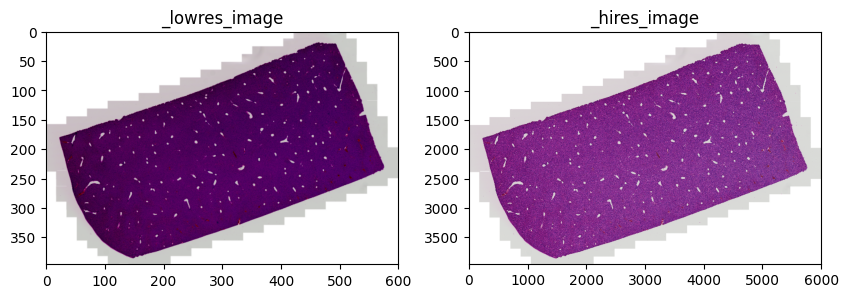

In [185]:
import matplotlib.pyplot as plt

axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten()
sdata.pl.render_images("_lowres_image").pl.show(ax=axes[0], title="_lowres_image")
sdata.pl.render_images("_hires_image").pl.show(ax=axes[1], title="_hires_image")

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from napari_spatialdata import Interactive

plt.rcParams['figure.figsize'] = (20, 20)

In [ ]:
interactive = Interactive(sdata)
interactive.run()
#napari lukt niet 

/home/sarah/napari-spatialdata/src/napari_spatialdata/_view.py:429: FutureWarning: Private attribute access ('Window._dock_widgets') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.6.0
  self._model = model if model else napari_viewer.window._dock_widgets["SpatialData"].widget().viewer_model._model
